# BNN on Pynq

This notebook covers how to use Binary Neural Networks on Pynq. 
It shows an example of handwritten character recognition using a binarized neural network composed of 4 fully connected layers with 1024 neurons each, trained on the NIST database of handwritten characters. 
In order to reproduce this notebook, you will need an external USB Camera connected to the PYNQ Board.

## 1. Import the package

In [1]:
import bnn

## 2. Checking available parameters

By default the following trained parameters are available for LFC network using 1 bit for weights and activation:

In [2]:
print(bnn.available_params(bnn.NETWORK_LFCW1A1))

['chars_merged', 'mnist']


Two sets of weights are available for the LFCW1A1 network, the MNIST and one for character recognition (NIST).

## 3. Instantiate the classifier

Creating a classifier will automatically download the correct bitstream onto the device and load the weights trained on the specified dataset. This example works with the LFCW1A1 to recognize handwritten characters.
Passing a runtime attribute will allow to choose between hardware accelerated or pure software inference.

In [3]:
hw_classifier = bnn.LfcClassifier(bnn.NETWORK_LFCW1A1,"chars_merged",bnn.RUNTIME_HW)
sw_classifier = bnn.LfcClassifier(bnn.NETWORK_LFCW1A1,"chars_merged",bnn.RUNTIME_SW)

In [4]:
print(hw_classifier.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


## 4. Load the image from the camera

The image is captured from the external USB camera and stored locally. The image is then enhanced in contrast and brightness to remove background noise. 
The resulting image should show the digit on a white background.

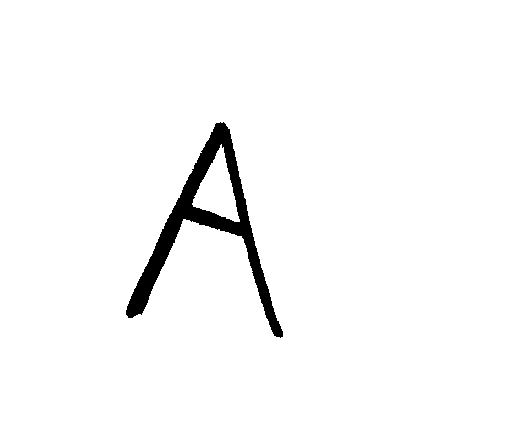

In [5]:
import cv2
from PIL import Image as PIL_Image
from PIL import ImageEnhance
from PIL import ImageOps


# says we capture an image from a webcam
cap = cv2.VideoCapture(0) 
_ , cv2_im = cap.read()
cv2_im = cv2.cvtColor(cv2_im,cv2.COLOR_BGR2RGB)
img = PIL_Image.fromarray(cv2_im).convert("L") 

#original captured image
#orig_img_path = '/home/xilinx/jupyter_notebooks/bnn/pictures/webcam_image_chars.jpg'
#img = PIL_Image.open(orig_img_path).convert("L")  

#Image enhancement                  
contr = ImageEnhance.Contrast(img)  
img = contr.enhance(5)                                                    # The enhancement values (contrast and brightness)   
bright = ImageEnhance.Brightness(img)                                     # depends on backgroud, external lights etc  
img = bright.enhance(2.0)            

#img = img.rotate(180)                                                     # Rotate the image (depending on camera orientation)  
#Adding a border for future cropping  
img = ImageOps.expand(img,border=80,fill='white')   
threshold = 180    
img = img.point(lambda p: p > threshold and 255)   
img


## 5. Crop and scale the image 

In [6]:
from PIL import Image as PIL_Image
import numpy as np
import math
from scipy import misc

#Find bounding box  
inverted = ImageOps.invert(img)  
box = inverted.getbbox()  
img_new = img.crop(box)  
width, height = img_new.size  
ratio = min((28./height), (28./width))  
background = PIL_Image.new('RGB', (28,28), (255,255,255))  
if(height == width):  
    img_new = img_new.resize((28,28))  
elif(height>width):  
    img_new = img_new.resize((int(width*ratio),28))  
    background.paste(img_new, (int((28-img_new.size[0])/2),int((28-img_new.size[1])/2)))  
else:  
    img_new = img_new.resize((28, int(height*ratio)))  
    background.paste(img_new, (int((28-img_new.size[0])/2),int((28-img_new.size[1])/2)))  
  
background  
img_data=np.asarray(background)  
img_data = img_data[:,:,0]  
misc.imsave('/home/xilinx/img_webcam_char.png', img_data) 

## 6. Convert to BNN input format
The image is resized to comply with the MNIST standard. The image is resized at 28x28 pixels and the colors inverted. 

In [7]:
from array import *
from PIL import Image as PIL_Image
from PIL import ImageOps
img_load = PIL_Image.open('/home/xilinx/img_webcam_char.png').convert("L")  
# Convert to BNN input format  
# The image is resized to comply with the MNIST standard. The image is resized at 28x28 pixels and the colors inverted.   
  
#Resize the image and invert it (white on black)  
smallimg = ImageOps.invert(img_load)  
smallimg = smallimg.rotate(0)  
  
data_image = array('B')  
  
pixel = smallimg.load()  
for x in range(0,28):  
    for y in range(0,28):  
        if(pixel[y,x] == 255):  
            data_image.append(255)  
        else:  
            data_image.append(1)  
          
# Setting up the header of the MNIST format file - Required as the hardware is designed for MNIST dataset         
hexval = "{0:#0{1}x}".format(1,6)  
header = array('B')  
header.extend([0,0,8,1,0,0])  
header.append(int('0x'+hexval[2:][:2],16))  
header.append(int('0x'+hexval[2:][2:],16))  
header.extend([0,0,0,28,0,0,0,28])  
header[3] = 3 # Changing MSB for image data (0x00000803)  
data_image = header + data_image  
output_file = open('/home/xilinx/img_webcam_processed', 'wb')  
data_image.tofile(output_file)  
output_file.close()   
smallimg

## 7. Launching BNN in hardware
Now, as the image has MNIST format, we can pass it to the PL and perform the inference

In [8]:
class_out=hw_classifier.classify_mnist("/home/xilinx/img_webcam_processed")
print("Class number: {0}".format(class_out))
print("Class name: {0}".format(hw_classifier.bnn.class_name(class_out)))

Inference took 7.00 microseconds
Classification rate: 142857.14 images per second
Class number: 10
Class name: A


## 8. Launching BNN in Software
For comparison we can also perform classification in software

In [9]:
class_out=sw_classifier.classify_mnist("/home/xilinx/img_webcam_processed")
print("Class number: {0}".format(class_out))
print("Class name: {0}".format(sw_classifier.bnn.class_name(class_out)))

Inference took 19212.00 microseconds
Classification rate: 52.05 images per second
Class number: 10
Class name: A


## 9. Reset the device


In [10]:
from pynq import Xlnk

xlnk = Xlnk()
xlnk.xlnk_reset()